<a href="https://colab.research.google.com/github/imamzmp/project-python/blob/main/text2im_modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# ✅ Install Glide-Text2IM dan dependensinya
!git clone https://github.com/openai/glide-text2im.git
%cd glide-text2im
!pip install -e .


Cloning into 'glide-text2im'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 76 (delta 26), reused 22 (delta 22), pack-reused 32 (from 1)
Receiving objects: 100% (76/76), 2.01 MiB | 28.58 MiB/s, done.
Resolving deltas: 100% (29/29), done.
/content/glide-text2im
Obtaining file:///content/glide-text2im
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00

In [2]:
from PIL import Image
from IPython.display import display
import torch as th

from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler
)

In [3]:
try:
    has_cuda = th.cuda.is_available()
    device = 'cuda' if has_cuda else 'cpu'
    print(f'Using device: {device}')
except Exception as e:
    print(f'Error checking CUDA: {e}')


Using device: cuda


In [4]:
# Create base model.
options = model_and_diffusion_defaults()
options['use_fp16'] = has_cuda
options['timestep_respacing'] = '100' # use 100 diffusion steps for fast sampling
model, diffusion = create_model_and_diffusion(**options)
model.eval()
if has_cuda:
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(load_checkpoint('base', device))
print('total base parameters', sum(x.numel() for x in model.parameters()))

  0%|          | 0.00/1.54G [00:00<?, ?iB/s]

total base parameters 385030726


In [5]:
# Create upsampler model.
options_up = model_and_diffusion_defaults_upsampler()
options_up['use_fp16'] = has_cuda
options_up['timestep_respacing'] = 'fast27' # use 27 diffusion steps for very fast sampling
model_up, diffusion_up = create_model_and_diffusion(**options_up)
model_up.eval()
if has_cuda:
    model_up.convert_to_fp16()
model_up.to(device)
model_up.load_state_dict(load_checkpoint('upsample', device))
print('total upsampler parameters', sum(x.numel() for x in model_up.parameters()))

  0%|          | 0.00/1.59G [00:00<?, ?iB/s]

total upsampler parameters 398361286


In [6]:
def show_images(batch: th.Tensor):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    display(Image.fromarray(reshaped.numpy()))
    # Save image
    img = Image.fromarray(reshaped.numpy())
    img.save('output.png')
    print('Image saved as output.png')


In [2]:
prompt = input('Enter prompt (default: an oil painting of a corgi): ').strip()
if not prompt:
    prompt = 'an oil painting of a corgi'
print(f'Using prompt: {prompt}')
batch_size = 1
guidance_scale = 3.0


Enter prompt (default: an oil painting of a corgi): cat laughing
Using prompt: cat laughing


  0%|          | 0.00/1.54G [00:00<?, ?iB/s]

  0%|          | 0/100 [00:00<?, ?it/s]

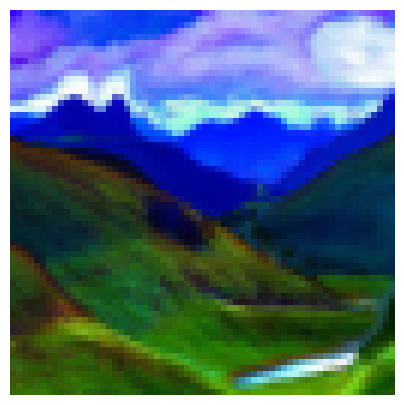

In [3]:
# ✅ Import
import torch as th
from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import create_model_and_diffusion, model_and_diffusion_defaults
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# ✅ Fungsi tampilkan gambar
def show_images(images_tensor):
    images_np = ((images_tensor + 1) * 127.5).clamp(0, 255).to(th.uint8).cpu().numpy()
    images_pil = [Image.fromarray(np.transpose(img, (1, 2, 0))) for img in images_np]
    fig, axs = plt.subplots(1, len(images_pil), figsize=(5 * len(images_pil), 5))
    if len(images_pil) == 1:
        axs = [axs]
    for ax, img in zip(axs, images_pil):
        ax.imshow(img)
        ax.axis("off")
    plt.show()

# ✅ Setup
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
batch_size = 1
guidance_scale = 5.0
prompt = "A fantasy landscape with mountains and rivers"

# ✅ Load base model
options = model_and_diffusion_defaults()
options['use_fp16'] = th.cuda.is_available()
options['timestep_respacing'] = '100'  # Fast sampling

model, diffusion = create_model_and_diffusion(**options)
model.load_state_dict(load_checkpoint('base', device))
model.to(device).eval()
if th.cuda.is_available():
    model.convert_to_fp16()

# ✅ Tokenisasi teks
tokens = model.tokenizer.encode(prompt)
tokens, mask = model.tokenizer.padded_tokens_and_mask(tokens, options['text_ctx'])

# ✅ Token untuk classifier-free guidance
full_batch_size = batch_size * 2
uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask([], options['text_ctx'])

model_kwargs = dict(
    tokens=th.tensor([tokens] * batch_size + [uncond_tokens] * batch_size, device=device),
    mask=th.tensor([mask] * batch_size + [uncond_mask] * batch_size, dtype=th.bool, device=device),
)

# ✅ Fungsi model_fn dengan guidance
def model_fn(x_t, ts, **kwargs):
    half = x_t[: len(x_t) // 2]
    combined = th.cat([half, half], dim=0)
    model_out = model(combined, ts, **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
    half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
    eps = th.cat([half_eps, half_eps], dim=0)
    return th.cat([eps, rest], dim=1)

# ✅ Sampling
samples = diffusion.p_sample_loop(
    model_fn,
    (full_batch_size, 3, options["image_size"], options["image_size"]),
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
)[:batch_size]

# ✅ Tampilkan gambar
show_images(samples)


  0%|          | 0/27 [00:00<?, ?it/s]

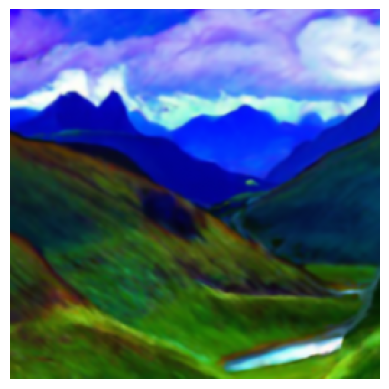

In [10]:
# ========================
# SETUP & IMPORT
# ========================
import torch as th
from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import create_model_and_diffusion, model_and_diffusion_defaults
from glide_text2im.tokenizer.bpe import get_encoder

# Siapkan device dan batch size
device = "cuda" if th.cuda.is_available() else "cpu"
batch_size = 1  # ubah sesuai kebutuhan

# Siapkan prompt dan encoder
prompt = "a futuristic hospital room"
enc = get_encoder()

# ========================
# LOAD UPSAMPLING MODEL
# ========================
from glide_text2im.model_creation import model_and_diffusion_defaults_upsampler
options_up = model_and_diffusion_defaults_upsampler()

options_up.update({
    'image_size': 256,
    'noise_schedule': 'linear',
    'timestep_respacing': '27',
    'use_fp16': th.cuda.is_available(),
})

# Buat model dan diffusion untuk upsampling
model_up, diffusion_up = create_model_and_diffusion(**options_up)
model_up.load_state_dict(load_checkpoint('upsample', device))
model_up.to(device).eval()

if th.cuda.is_available():
    model_up.convert_to_fp16()

# ========================
# PREPARE TOKENS DAN SAMPLES
# ========================
# Ambil token dari prompt
tokens = enc.encode(prompt)
tokens, mask = enc.padded_tokens_and_mask(tokens, options_up['text_ctx'])

# Pastikan variabel `samples` sudah ada dari model dasar 64x64
# Contoh placeholder:
# samples = base64_model_output  # Harus diganti dengan hasil sebenarnya dari model dasar

# Siapkan conditioning dictionary
model_kwargs = dict(
    low_res=((samples + 1) * 127.5).round() / 127.5 - 1,  # normalisasi
    tokens=th.tensor([tokens] * batch_size, device=device),
    mask=th.tensor([mask] * batch_size, dtype=th.bool, device=device),
)

# ========================
# UPSAMPLE
# ========================
upsample_temp = 0.997
up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])

model_up.del_cache()
up_samples = diffusion_up.ddim_sample_loop(
    model_up,
    up_shape,
    noise=th.randn(up_shape, device=device) * upsample_temp,
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
)[:batch_size]
model_up.del_cache()

# ========================
# TAMPILKAN HASIL
# ========================
def show_images(images):
    import matplotlib.pyplot as plt
    import numpy as np
    images = (images + 1) / 2  # dari [-1, 1] ke [0, 1]
    images = images.clamp(0, 1)
    for img in images:
        plt.figure()
        plt.imshow(img.permute(1, 2, 0).cpu().numpy())
        plt.axis("off")
    plt.show()

show_images(up_samples)
